In [2]:
# Basic imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv 
import os
import time
import datetime
import random
import torch
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image

C:\Users\cristina soler\Documents\UNIVERSITAT programes\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Descripció de dades

In [3]:
labels = pd.read_csv("labels.csv")
labels
len(labels['breed'].unique())

120

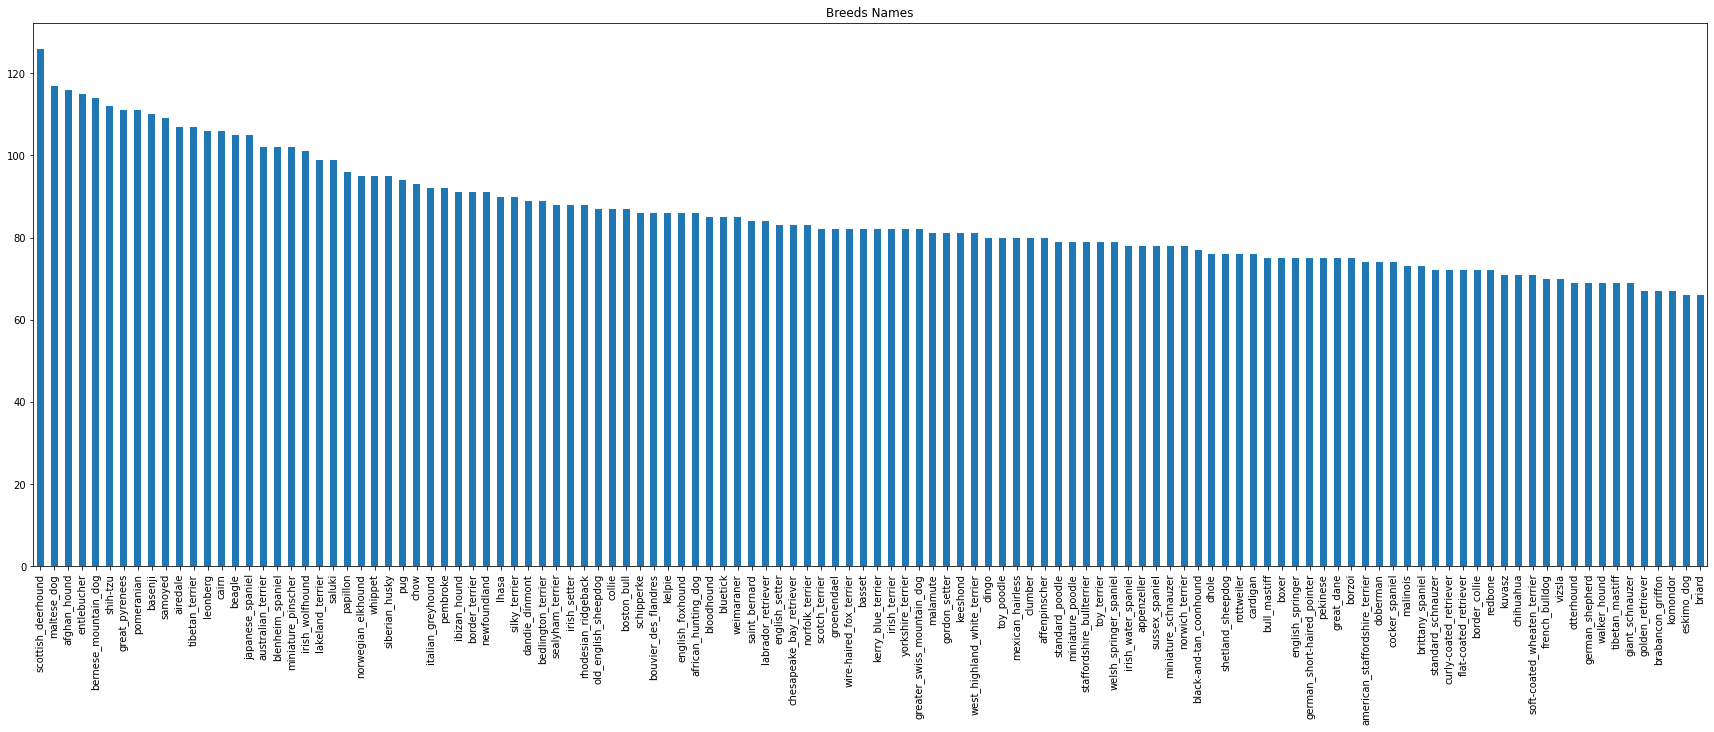

In [4]:
labels.breed.value_counts().plot(kind='bar',figsize=(30,10),title='Breeds Names');

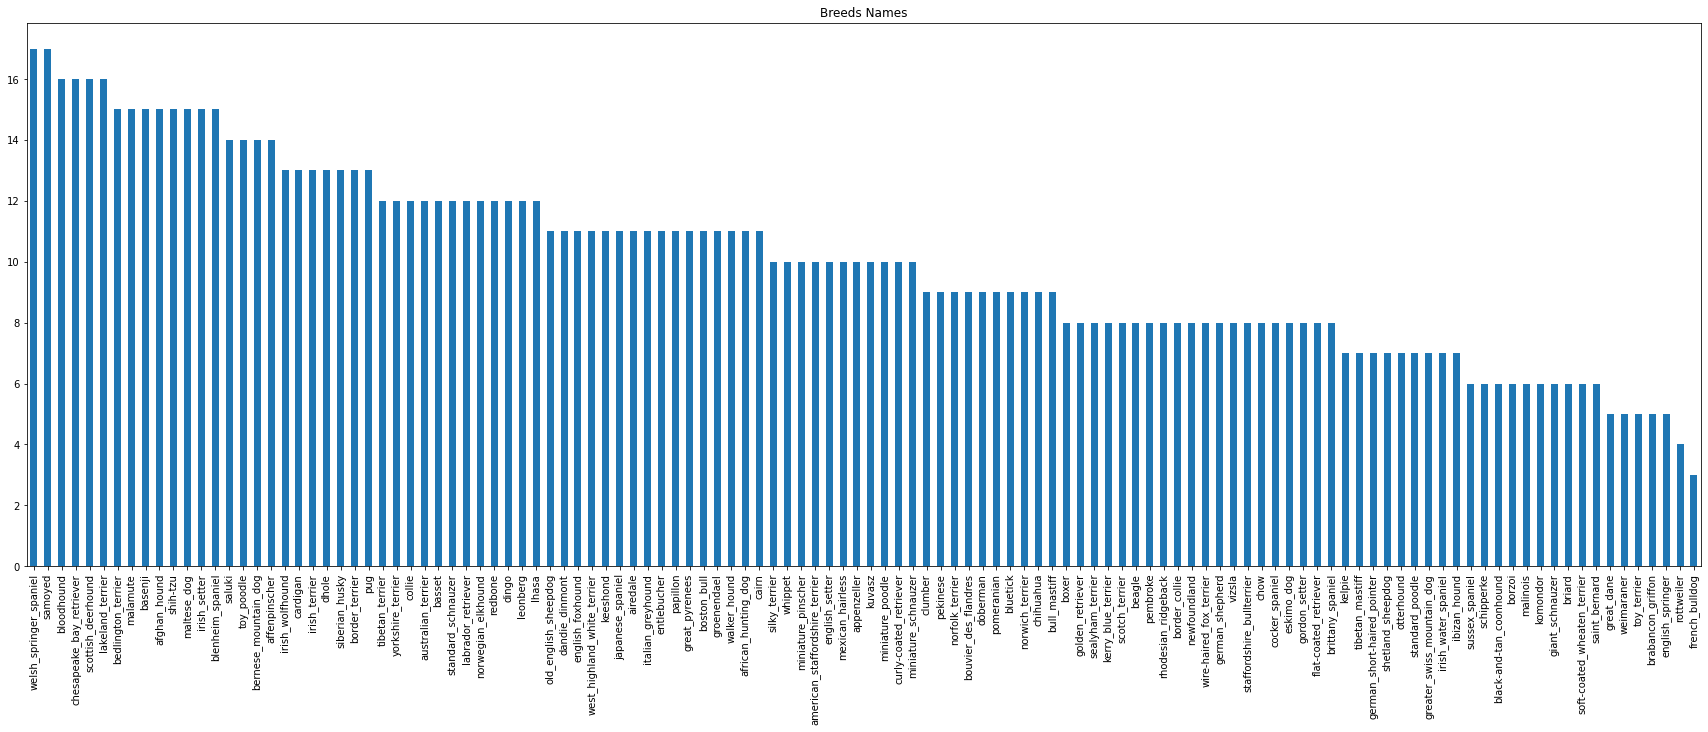

In [19]:
a = labels[0:1200]

a.breed.value_counts().plot(kind='bar',figsize=(30,10),title='Breeds Names');

In [20]:
len(a['breed'].unique())

120

In [5]:
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
#Fem un label encoder per tenir les raçes en funció de un nombre
labels2 = labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels2['num'] = le.fit_transform(labels2.breed)
labels2.head()

,id,breed,num
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [7]:
df = labels2[['breed', 'num']]
df.head()

,breed,num
0,boston_bull,19
1,dingo,37
2,pekinese,85
3,bluetick,15
4,golden_retriever,49


In [8]:
#Guardem els valors que correspoenen al label
taula = df.drop_duplicates(subset = "breed")
taula

,breed,num
0,boston_bull,19
1,dingo,37
2,pekinese,85
3,bluetick,15
4,golden_retriever,49
...,...,...
441,bouvier_des_flandres,20
443,tibetan_mastiff,108
466,english_springer,41
478,cocker_spaniel,32


## Mirem com són les imatges

In [9]:
X = labels.id
y = labels.num

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.4, random_state=SEED, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid)

In [10]:
class Dataset_Interpreter(Dataset):
    """Dog breed identification dataset."""
    def __init__(self, data_path, file_names, labels=None, transforms=None):
        """
        Args:
            data_path (string): Directory with all the images.        
            dataframe (pandas.core.frame.DataFrame): Pandas dataframe obtained
                by read_csv().
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return np.array(image), label

In [11]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{le.inverse_transform([images[i][1]])}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

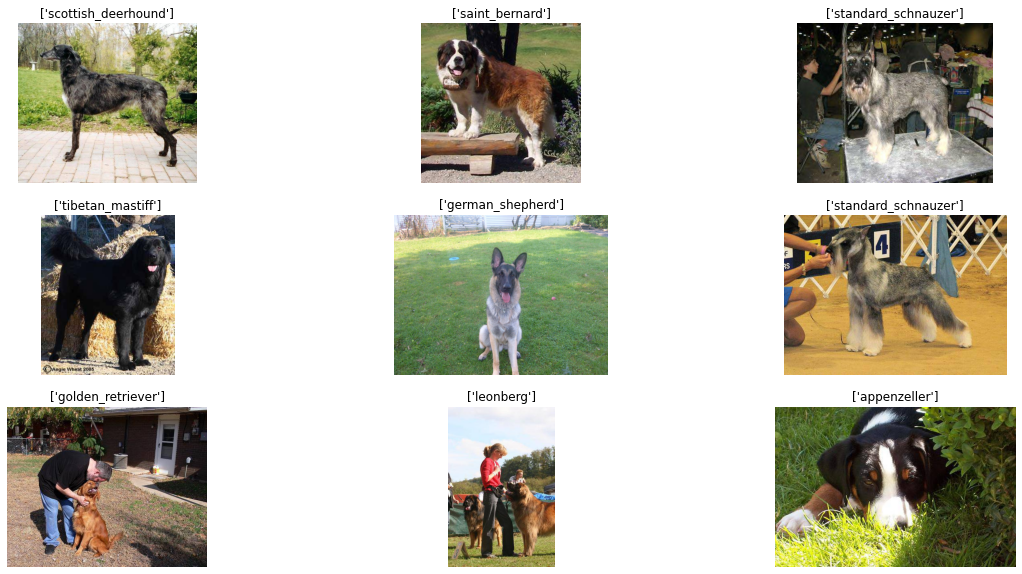

In [11]:
N_IMAGES = 9
X = labels.id
y = labels.breed

train_data = Dataset_Interpreter(data_path='train/', file_names=X_train, labels=y_train)
images = [(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

# Eliminació del fons

In [12]:
#!pip install rembg --user --no-warn-script-location

In [16]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Cambiar per els paths corresponents
dirc = 'drive/MyDrive/test1000'
dircout = 'drive/MyDrive/test1000without'

files_names = os.listdir(dirc)
for file_name in files_names:
  input_path = dirc + '/' + file_name
  output_path = dircout + '/' + file_name

  input = Image.open(input_path).convert('RGB')
  input.save(file_name)
  output = remove(input)
  output.save(output_path, format ='PNG')

C:\Users\cristina soler\Documents\UNIVERSITAT programes\lib\site-packages\numba\core\types\__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.
  long_ = _make_signed(np.long)


AttributeError: module 'numpy' has no attribute 'long'

# Definició de train i early stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train(model,train_loader,valid_loader,patience,n_epochs,criterion,optimizer):
    
    # Track training loss as the model train
    train_losses = []
    # Track the validation loss as the model train
    valid_losses = []
    # Track the average training loss per epoch
    avg_train_losses = []
    # Track the average validation loss per epoch
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in tqdm(range(1,n_epochs+1)):
        
        model.train()
        for batch,(data,target) in enumerate(train_loader,1):
            data,target = data.to(cfg.DEVICE),target.to(cfg.DEVICE)
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output,target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data,target = data.to(cfg.DEVICE),target.to(cfg.DEVICE)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())
            
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return  model, avg_train_losses, avg_valid_losses

In [ ]:
def plot_loss(fold,train_loss,valid_loss):
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
    
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.title(f"Plot for fold={fold}")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 0.5) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

# MODELS

In [ ]:
#RESNET ja preentrenada
use_gpu = torch.cuda.is_available()
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048,120)
model = model.to(device = cfg.DEVICE)